In [1]:
import torch
import torchvision
import torch.nn as nn

c:\Users\Robotics\anaconda3\envs\Project_v1\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import random
import matplotlib.pyplot as plt

# 0. Use device to acclerate experiment time
# device = 'cpu'
device = 'cuda:0'

n = 32
N = 10000
# 1. 100 is not enough, 10000 should do the job

x_list = []
y_list = []

for i in range(N):
    x = torch.linspace(-1, 1, n)
    mode = random.randint(0, 1)
    if mode == 0:
        y = torch.linspace(-2, 2, n)
    else:
        y = torch.linspace(2, -2, n)
    
    noise_x = 0.02 * torch.randn(n)
    noise_y = 0.02 * torch.randn(n)
    x = x + noise_x
    y = y + noise_y
    x_list.append(x)
    y_list.append(y)

x = torch.stack(x_list)
y = torch.stack(y_list)

data = torch.stack((x, y), dim=1)
print(data.shape)


torch.Size([10000, 2, 32])


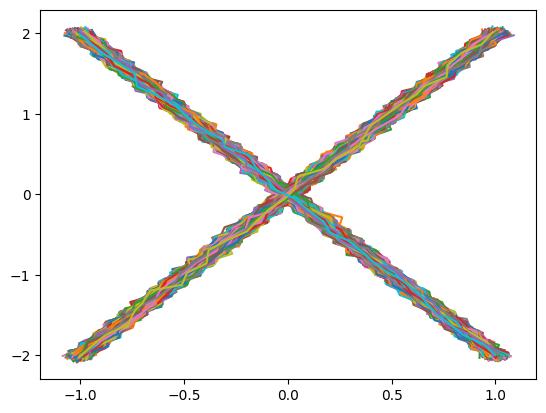

In [3]:
plt_data = data.cpu().numpy()
plt.plot(plt_data[:, 0, :].T, plt_data[:, 1, :].T);

In [4]:
data = data.to(device=device)

In [5]:
'''
Define a sequence of sigma_t's.
'''
def make_beta_schedule(schedule='linear', n_timesteps=1000, start=1e-5, end=1e-2):
    if schedule == 'linear':
        betas = torch.linspace(start, end, n_timesteps)
    elif schedule == "quad":
        betas = torch.linspace(start ** 0.5, end ** 0.5, n_timesteps) ** 2
    elif schedule == "constant":
        betas = torch.ones(n_timesteps) * start
    return betas

In [6]:
"""initialize diffusion-related constant"""
beta_schedule = 'linear'
n_timesteps = 1000
beta_start, beta_end = 1e-3, 1e-2
# beta_start, beta_end = 1e-4, 1e-3
betas = make_beta_schedule(
    schedule=beta_schedule,
    n_timesteps=n_timesteps,
    start=beta_start,
    end=beta_end,
).to(device=device)

alphas = 1 - betas
alphas_prod = torch.cumprod(alphas, 0)
alphas_prod_p = torch.cat([torch.tensor([1]).float().to(device=device), alphas_prod[:-1]], 0)
alphas_bar_sqrt = torch.sqrt(alphas_prod)
one_minus_alphas_bar_log = torch.log(1 - alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)

In [7]:
def q_sample(x_start, t):
    global alphas_bar_sqrt, one_minus_alphas_bar_sqrt
    noise = torch.randn(*x_start.shape, device=x_start.device)
    x_t = alphas_bar_sqrt[t - 1] * x_start + one_minus_alphas_bar_sqrt[t - 1] * noise
    return x_t

In [8]:
# fig = plt.figure()
# plot_data = data

# data_diffused = q_sample(plot_data, 250).to('cpu').numpy()

# ax = fig.add_subplot(2, 2, 1)
# ax.scatter(data_diffused[:, 0, :], data_diffused[:, 1, :], s=5)

# data_diffused = q_sample(data, 500).to('cpu').numpy()

# ax = fig.add_subplot(2, 2, 2)
# ax.scatter(data_diffused[:, 0, :], data_diffused[:, 1, :], s=5)

# data_diffused = q_sample(data, 750).to('cpu').numpy()

# ax = fig.add_subplot(2, 2, 3)
# ax.scatter(data_diffused[:, 0, :], data_diffused[:, 1, :], s=5)

# data_diffused = q_sample(plot_data, 1000).to('cpu').numpy()

# ax = fig.add_subplot(2, 2, 4)
# ax.scatter(data_diffused[:, 0, :], data_diffused[:, 1, :], s=5)

# print(torch.std_mean(data, dim = 0))
# print(torch.std_mean(latent_diffused, dim = 0))

In [9]:
batch_size = 32
n_class = 1

In [10]:
import torch
from positional_encodings.torch_encodings import PositionalEncoding1D, PositionalEncoding2D, PositionalEncoding3D, Summer

# Returns the position encoding only
p_enc_1d_model = PositionalEncoding1D(10)

# Return the inputs with the position encoding added
p_enc_1d_model_sum = Summer(PositionalEncoding1D(10))

x = torch.rand(1,6,10)
penc_no_sum = p_enc_1d_model(x) # penc_no_sum.shape == (1, 6, 10)
penc_sum = p_enc_1d_model_sum(x)

In [11]:
from positional_encodings.torch_encodings import PositionalEncoding3D, PositionalEncoding1D

#3. I think this version is better
def time_embed(time_length, feature_dim, device='cpu'):
  pos_encoder = PositionalEncoding1D(feature_dim)
  z = torch.zeros(1, time_length, feature_dim)
  return pos_encoder(z).transpose(-2, -1).to(device=device)

print(time_embed(10, 16).shape)
print(time_embed(10, 16)[0])

torch.Size([1, 16, 10])
tensor([[ 0.0000e+00,  8.4147e-01,  9.0930e-01,  1.4112e-01, -7.5680e-01,
         -9.5892e-01, -2.7942e-01,  6.5699e-01,  9.8936e-01,  4.1212e-01],
        [ 1.0000e+00,  5.4030e-01, -4.1615e-01, -9.8999e-01, -6.5364e-01,
          2.8366e-01,  9.6017e-01,  7.5390e-01, -1.4550e-01, -9.1113e-01],
        [ 0.0000e+00,  3.1098e-01,  5.9113e-01,  8.1265e-01,  9.5358e-01,
          9.9995e-01,  9.4715e-01,  8.0042e-01,  5.7432e-01,  2.9126e-01],
        [ 1.0000e+00,  9.5042e-01,  8.0658e-01,  5.8275e-01,  3.0114e-01,
         -1.0342e-02, -3.2080e-01, -5.9944e-01, -8.1863e-01, -9.5664e-01],
        [ 0.0000e+00,  9.9833e-02,  1.9867e-01,  2.9552e-01,  3.8942e-01,
          4.7943e-01,  5.6464e-01,  6.4422e-01,  7.1736e-01,  7.8333e-01],
        [ 1.0000e+00,  9.9500e-01,  9.8007e-01,  9.5534e-01,  9.2106e-01,
          8.7758e-01,  8.2534e-01,  7.6484e-01,  6.9671e-01,  6.2161e-01],
        [ 0.0000e+00,  3.1618e-02,  6.3203e-02,  9.4726e-02,  1.2615e-01,
        

In [12]:
"""Pytorch version of https://pasus.tistory.com/204"""

import torch.nn as nn

class ConvBlock(nn.Module):
  def __init__(self, channels_1, channels_2):
    super(ConvBlock, self).__init__()

    self.conv1 = nn.Conv1d(channels_1, channels_2, 5, padding='same')
    self.conv2 = nn.Conv1d(channels_2, channels_2, 5, padding='same')

    self.bn1 = nn.BatchNorm1d(channels_2)
    self.bn2 = nn.BatchNorm1d(channels_2)

    self.activation = nn.ReLU()

  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.activation(x)

    x = self.conv2(x)
    x = self.bn2(x)
    x = self.activation(x)
    return x

class EncoderBlock(nn.Module):
  def __init__(self, channels_1, channels_2):
    super(EncoderBlock, self).__init__()

    self.conv_blk = ConvBlock(channels_1, channels_2)
    self.pool = nn.MaxPool1d(2)

  def forward(self, x):
    x = self.conv_blk(x)
    p = self.pool(x)
    return x, p

class DecoderBlock(nn.Module):
  def __init__(self, channels_1, channels_2):
    super(DecoderBlock, self).__init__()

    self.up = nn.ConvTranspose1d(channels_1, channels_2, 2, stride = 2)    # padding?
    self.conv_blk = ConvBlock(channels_1, channels_2)

  def forward(self, x, skip):
    x = self.up(x)
    x = torch.concat([x, skip], dim = 1)
    x = self.conv_blk(x)

    return x

class UNET(nn.Module):
  def __init__(self):
    super(UNET, self).__init__()

    self.e1 = EncoderBlock(2, 32)
    self.e2 = EncoderBlock(32, 64)

    self.b = ConvBlock(64, 128)

    self.d1 = DecoderBlock(128, 64)
    self.d2 = DecoderBlock(64, 32)

    self.outputs = nn.Conv1d(32, 2, 1)
    # self.activation = nn.ReLU()

  def forward(self, inputs, t):
    batch_size = inputs.size()[0]
    image_size_1 = inputs.size()[-2]
    image_size_2 = inputs.size()[-1]
    
    # s1, p1 = self.e1(inputs + time_embed(n_timesteps, 2, device=device)[:, :, t].transpose(-1, 0)) # time embed is used too redundantly -> Problem! print time_embed(n_timesteps, image_size_2)[:, :, :, :, t].squeeze(-1).transpose(0, -1).squeeze(-1).squeeze(-1)
    s1, p1 = self.e1(inputs) 
    s2, p2 = self.e2(p1 + time_embed(n_timesteps, 32, device=device)[:, :, t].transpose(-1, 0)) # Why are you dividing with /2?
    # 5. The variables in time_embed should be switched (I think...) -> Then why does this code work?
    # 6. It would be better (or easier) to give time variable to Encoder, Decoder block instead of adding it explicitly to the network.

    b = self.b(p2 + time_embed(n_timesteps, 64, device=device)[:, :, t].transpose(-1, 0))

    d1 = self.d1(b + time_embed(n_timesteps, 128, device=device)[:, :, t].transpose(-1, 0), s2)
    d2 = self.d2(d1 + time_embed(n_timesteps, 64, device=device)[:, :, t].transpose(-1, 0), s1)

    outputs = self.outputs(d2)

    return outputs

In [13]:
import torch.optim as optim

eps_network = UNET().to(device=device)
criterion = nn.MSELoss()
optimizer = optim.Adam(eps_network.parameters(), lr=1e-3)

In [14]:
import random
from tqdm import tqdm

num_class = 1
batch_size = 32
dataset_size = 10000
data_size_1 = 2
data_size_2 = n
l_losses = []
      
for episode in tqdm(range (5000)):
  # Line 2 of DDPM paper
  index = random.choices(range(dataset_size), k = batch_size)
  data_select = data[index, :, :]
  # Line 3 of DDPM paper
  t = random.choices(range(n_timesteps), k = batch_size)
  # Line 4 of DDPM paper
  eps = torch.randn(batch_size, data_size_1, data_size_2, device=device)
  #Line 5 of DDPM paper
  input = alphas_bar_sqrt[t].unsqueeze(-1).unsqueeze(-1) * data_select + one_minus_alphas_bar_sqrt[t].unsqueeze(-1).unsqueeze(-1) * eps
  eps_estimate = eps_network(input, t)
  
  optimizer.zero_grad()
  loss = criterion(eps, eps_estimate)
  l_losses.append(loss.item())
  loss.backward()
  torch.nn.utils.clip_grad_norm_(eps_network.parameters(), 1.)
  optimizer.step()

  # if episode % 1000 == 0:
    # print(loss)


# eps_network.load_state_dict(torch.load('./Trajectory Diffusion'))

100%|██████████| 5000/5000 [01:39<00:00, 50.26it/s]


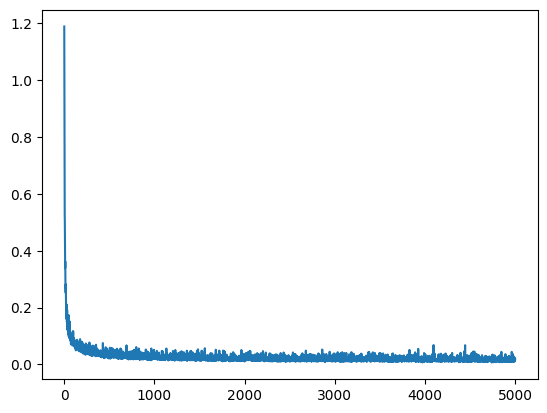

In [15]:
plt.plot(l_losses)

In [16]:
eps_network.eval();

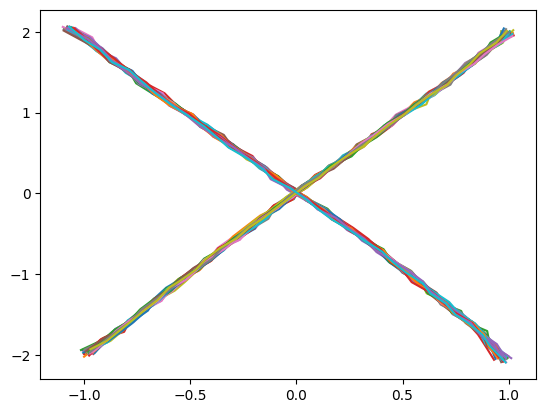

In [17]:
"""Unconditional"""
with torch.no_grad():
  batch_size = 100
  noise_data = torch.randn(batch_size, data_size_1, data_size_2, device=device)

  for t in range(n_timesteps, 0, -1):
    t_l = [t - 1] * batch_size
    noise = torch.randn(batch_size, data_size_1, data_size_2, device=device)
    eps_estimate = eps_network(noise_data, t_l)
    noise_data = 1 / alphas[t - 1].sqrt() * (noise_data - betas[t - 1] / one_minus_alphas_bar_sqrt[t - 1] * eps_estimate) + 0.2 * betas[t - 1].sqrt() * noise
    # if t == 1:
    #   noise_data = noise_data - betas[t - 1].sqrt() * noise
    
sampled = noise_data.reshape(-1, 2, n).cpu().numpy()
sampled_x = sampled[:, 0, :]
sampled_y = sampled[:, 1, :]

# fig = plt.figure()    
# ax = fig.add_subplot(1, 1, 1)
# ax.scatter(sampled_x.transpose(1, 0), sampled_y.transpose(1, 0))

plt.plot(sampled_x.transpose(1, 0), sampled_y.transpose(1, 0));

(-2.5, 2.5)

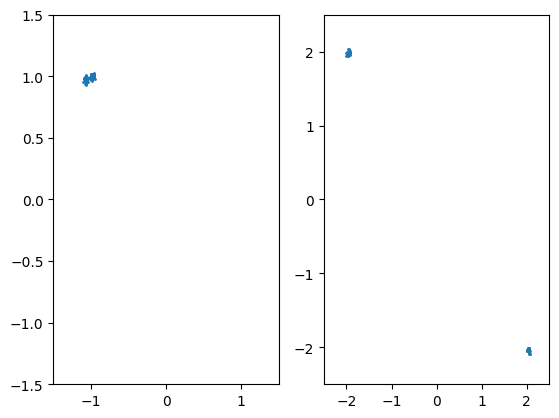

In [18]:
sampled_x_init = sampled[:, 0, 0]
sampled_x_term = sampled[:, 0, n - 1]

fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.scatter(sampled_x_init, sampled_x_term, s=1)
plt.xlim([-1.5, 1.5])
plt.ylim([-1.5, 1.5])

sampled_y_init = sampled[:, 1, 0]
sampled_y_term = sampled[:, 1, n - 1]

ax = fig.add_subplot(1, 2, 2)
ax.scatter(sampled_y_init, sampled_y_term,s=1)
plt.xlim([-2.5, 2.5])
plt.ylim([-2.5, 2.5])

In [19]:
def dist_sq(p1, p2):
    return (p1[0]-p2[0]) ** 2 + (p1[1]-p2[1]) ** 2

0 49 0 51 0


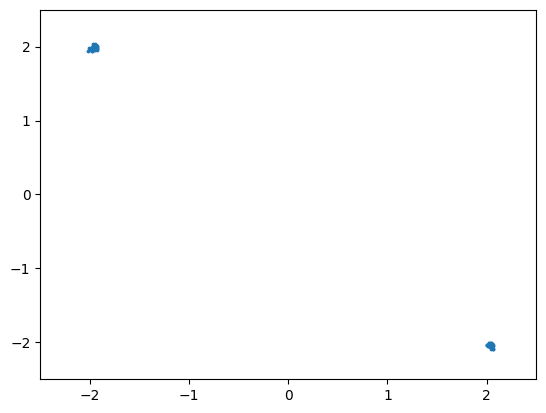

In [20]:
fig = plt.figure()

sampled_y_init = sampled[:, 1, 0]
sampled_y_term = sampled[:, 1, n - 1]

ax = fig.add_subplot(1, 1, 1)
ax.scatter(sampled_y_init, sampled_y_term, s=3)
plt.xlim([-2.5, 2.5])
plt.ylim([-2.5, 2.5])

type1 = 0
type2 = 0
type3 = 0
type4 = 0
none = 0
for i in range(batch_size):
    point = [sampled_y_init[i], sampled_y_term[i]]
    if dist_sq(point, [2, 2]) < 0.25:
        type1 = type1 + 1
    elif dist_sq(point, [-2, 2]) < 0.25:
        type2 = type2 + 1
    elif dist_sq(point, [-2, -2]) < 0.25:
        type3 = type3 + 1
    elif dist_sq(point, [2, -2]) < 0.25:
        type4 = type4 + 1
    else:
        none = none + 1
print(type1, type2, type3, type4, none)
    

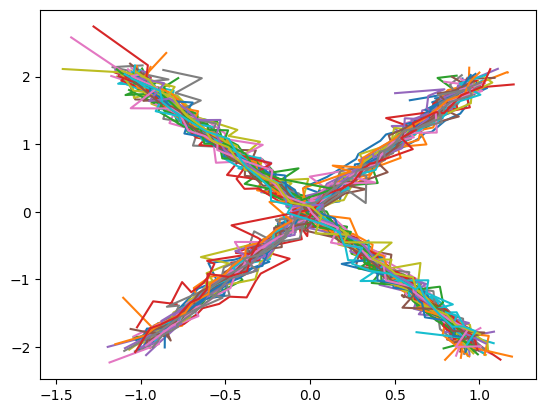

In [21]:
"""DDIM, sigma = 0"""
with torch.no_grad():
  batch_size = 100
  noise_data = torch.randn(batch_size, data_size_1, data_size_2, device=device)
  T = 100
  interval = int(n_timesteps / T)

  for t in range(n_timesteps, 0, -interval):
    t_l = [t - 1] * batch_size
    # noise = torch.randn(batch_size, data_size_1, data_size_2, device=device)
    eps_estimate = eps_network(noise_data, t_l)
    x0_pred = (noise_data - one_minus_alphas_bar_sqrt[t - 1] * eps_estimate) / alphas_bar_sqrt[t - 1]
    if t > interval:
      noise_data = alphas_bar_sqrt[t - 1 - interval] * x0_pred + one_minus_alphas_bar_sqrt[t - 1 - interval] * eps_estimate
    else:
      noise_data = x0_pred
    
sampled = noise_data.reshape(-1, 2, n).cpu().numpy()
sampled_x = sampled[:, 0, :]
sampled_y = sampled[:, 1, :]

# fig = plt.figure()    
# ax = fig.add_subplot(1, 1, 1)
# ax.scatter(sampled_x.transpose(1, 0), sampled_y.transpose(1, 0))

plt.plot(sampled_x.transpose(1, 0), sampled_y.transpose(1, 0));

In [22]:
def ddpm_sig_sq(alphas_prod, t, interval):
    return (1 - alphas_prod[t - 1 - interval]) / (1 - alphas_prod[t - 1]) * (1 - alphas_prod[t - 1] / alphas_prod[t - 1 - interval])

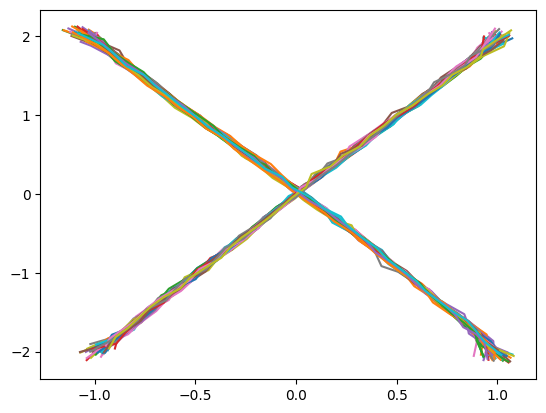

In [23]:
"""DDIM, sigma retrieved from the function above"""
with torch.no_grad():
  batch_size = 100
  noise_data = torch.randn(batch_size, data_size_1, data_size_2, device=device)
  T = 100
  interval = int(n_timesteps / T)

  for t in range(n_timesteps, 0, -interval):
    t_l = [t - 1] * batch_size
    noise = torch.randn(batch_size, data_size_1, data_size_2, device=device)
    eps_estimate = eps_network(noise_data, t_l)
    x0_pred = (noise_data - one_minus_alphas_bar_sqrt[t - 1] * eps_estimate) / alphas_bar_sqrt[t - 1]
    if t > interval:
      # noise_data = alphas_bar_sqrt[t - 1 - interval] * x0_pred + one_minus_alphas_bar_sqrt[t - 1 - interval] * eps_estimate
      noise_data = alphas_bar_sqrt[t - 1 - interval] * x0_pred + (1 - alphas_prod[t - 1 - interval] - ddpm_sig_sq(alphas_prod, t, interval)) * eps_estimate + ddpm_sig_sq(alphas_prod, t, interval).sqrt() * noise
    else:
      noise_data = x0_pred
    
sampled = noise_data.reshape(-1, 2, n).cpu().numpy()
sampled_x = sampled[:, 0, :]
sampled_y = sampled[:, 1, :]

# fig = plt.figure()    
# ax = fig.add_subplot(1, 1, 1)
# ax.scatter(sampled_x.transpose(1, 0), sampled_y.transpose(1, 0))

plt.plot(sampled_x.transpose(1, 0), sampled_y.transpose(1, 0));

In [24]:
import pickle

"""Save model and loss"""
# torch.save(eps_network.state_dict(), './Trajectory Diffusion 0118')
# with open('Trajectory Diffusion Loss', 'wb') as f1:
#     pickle.dump(l_losses, f1)
# with open('Desirable Traj', 'wb') as f1:
#     pickle.dump(r_process, f1)


'Save model and loss'

In [25]:
"""Data generation code for ./Epsilon Tracking Data/"""
# with torch.no_grad():
#   batch_size = 1
#   noise_data = torch.randn(batch_size, data_size_1, data_size_2, device=device)
#   r_process = [noise_data]

#   for t in range(n_timesteps, 0, -1):
#     t_l = [t - 1] * batch_size
#     noise = torch.randn(batch_size, data_size_1, data_size_2, device=device)
#     eps_estimate = eps_network(noise_data, t_l)
#     noise_data = 1 / alphas[t - 1].sqrt() * (noise_data - betas[t - 1] / one_minus_alphas_bar_sqrt[t - 1] * eps_estimate) + 0.2 * betas[t - 1].sqrt() * noise
#     r_process.append(noise_data)
#     # if t == 1:
#     #   noise_data = noise_data - betas[t - 1].sqrt() * noise
    
# sampled = noise_data.reshape(-1, 2, n).cpu().numpy()
# sampled_x = sampled[:, 0, :]
# sampled_y = sampled[:, 1, :]

# # fig = plt.figure()    
# # ax = fig.add_subplot(1, 1, 1)
# # ax.scatter(sampled_x.transpose(1, 0), sampled_y.transpose(1, 0))

# plt.plot(sampled_x.transpose(1, 0), sampled_y.transpose(1, 0));

'Data generation code for ./Epsilon Tracking Data/'